## Task 3: Transfer Learning

In [ ]:
import numpy as np
from tensorflow.keras.applications import ResNet50V2
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Dropout, Input, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import keras_tuner as kt
from keras_tuner.tuners import Hyperband
import pandas as pd

from funcs_Task1 import training_data_Pipeline, test_validation_data_Pipeline, test_data_Pipeline_non_normalized
from funcs_Task3 import plot_accuracy_loss, concat_generators, plot_confusion_matrix

In [3]:
# constants
img_height = img_width = 128
batch_size = 128
img_size = (img_height, img_width)

train_dir = 'covid xray/train'
val_dir = 'covid xray/val'
test_dir = 'covid xray/test'

epochs=30


### 1. Classification Set-Up

In [4]:
np.random.seed(123)
metrics = ["accuracy"]

### 2. Setting Up the Base Model

In [5]:
# instantiate pre-trained model and freeze layers
ResNet_model = ResNet50V2(
    include_top=False,
    weights="imagenet",
)

ResNet_model.trainable = False

In [ ]:
# add extra layers to model
inputs = Input(shape=(img_height, img_width, 3))
x = ResNet_model(inputs, training = False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model = keras.Model(
    inputs,
    outputs
)

# print architecture
model.summary(show_trainable = True)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_4 (InputLayer)  │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ resnet50v2 (Functional)     │ (None, 4, 4, 2048)    │ 23,564,800 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_4 (Dense)             │ (None, 128)           │    262,272 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_4 (Dropout)         │ (None, 128)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_5 (Dense)             │ (None, 1)             │        129 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 23,827,201 (90.89 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

### 3. Model Training

In [12]:
# compile model and fetch training and validation data
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics= metrics)

train_data_gen = training_data_Pipeline(batch_size, img_size, train_dir)
val_data_gen = test_validation_data_Pipeline(batch_size, img_size, test_dir = val_dir, train_dir = train_dir)

total_train=train_data_gen.samples
total_val = val_data_gen.samples

Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [13]:
# train model
history = model.fit(
    train_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 470ms/step - accuracy: 0.6964 - loss: 0.8315 - val_accuracy: 0.7083 - val_loss: 0.6000
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 379ms/step - accuracy: 0.7860 - loss: 0.4627 - val_accuracy: 0.6849 - val_loss: 0.7556
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 344ms/step - accuracy: 0.8131 - loss: 0.4290 - val_accuracy: 0.7240 - val_loss: 0.5722
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 344ms/step - accuracy: 0.8079 - loss: 0.3914 - val_accuracy: 0.7604 - val_loss: 0.5444
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 349ms/step - accuracy: 0.8166 - loss: 0.3678 - val_accuracy: 0.7656 - val_loss: 0.5721
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 346ms/step - accuracy: 0.8086 - loss: 0.4067 - val_accuracy: 0.7812 - val_loss: 0.4980
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 330ms/step - accuracy: 0.8566 - loss: 0.3274 - val_accuracy: 0.7604 - val_loss: 0.5240
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 341ms/step - accuracy: 0.8536 - loss: 0.3280 - val_accu

In [1]:
plot_accuracy_loss(history, epochs)

NameError: name 'plot_accuracy_loss' is not defined

### 4. Hyperparameter Tuning

In [15]:
tf.config.run_functions_eagerly(True)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tf.config.run_functions_eagerly(False)

In [16]:
inputs = Input(shape=(img_height, img_width, 3))
x = ResNet_model(inputs, training = False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model = keras.Model(
    inputs,
    outputs
)
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics= metrics)

early_history = model.fit(
    train_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    callbacks = [early_stop]
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 388ms/step - accuracy: 0.6853 - loss: 0.9652 - val_accuracy: 0.7031 - val_loss: 0.6070
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 350ms/step - accuracy: 0.8004 - loss: 0.4176 - val_accuracy: 0.6510 - val_loss: 0.5997
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 345ms/step - accuracy: 0.8055 - loss: 0.4145 - val_accuracy: 0.7292 - val_loss: 0.5586
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 347ms/step - accuracy: 0.8232 - loss: 0.3849 - val_accuracy: 0.7318 - val_loss: 0.5702
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 339ms/step - accuracy: 0.8270 - loss: 0.3620 - val_accuracy: 0.7552 - val_loss: 0.5003
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 352ms/step - accuracy: 0.8293 - loss: 0.3722 - val_accuracy: 0.7682 - val_loss: 0.4966
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 341ms/step - accuracy: 0.8447 - loss: 0.3426 - val_accuracy: 0.7500 - val_loss: 0.5099
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 335ms/step - accuracy: 0.8484 - loss: 0.3197 - val_accu

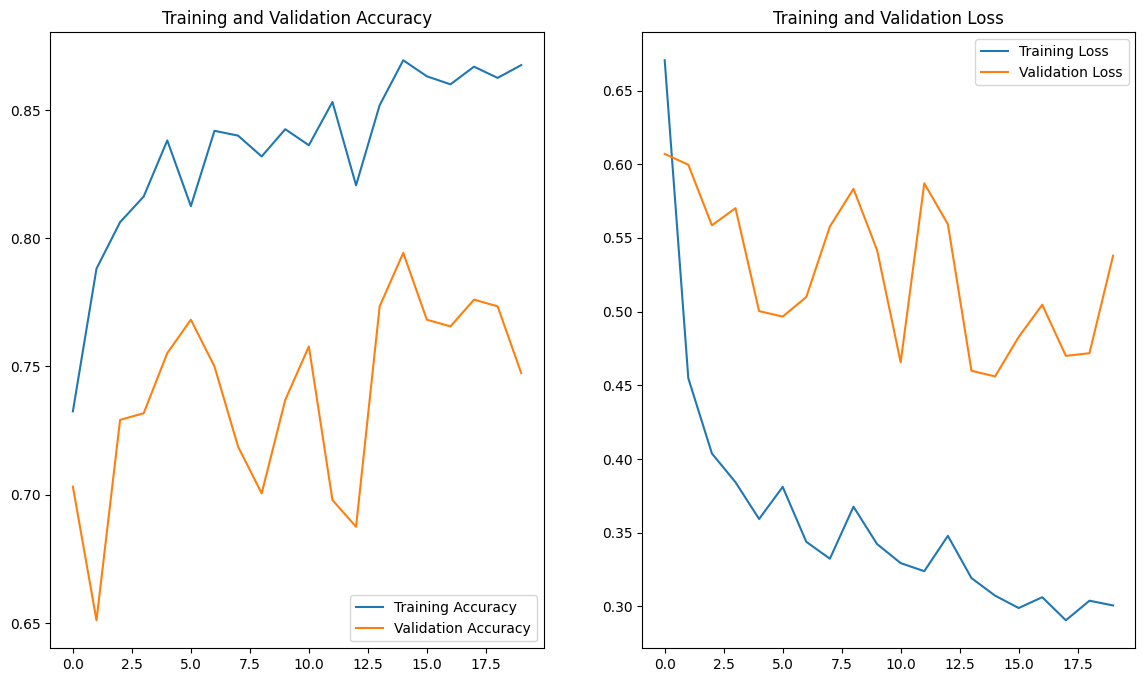

In [ ]:
plot_accuracy_loss(history, epochs)

In [ ]:
# OPTION 1: Loop over different combinations of hyperparameters
# runs a very long time (>1h)

batch_sizes = [32, 64, 128]
learning_rates = [0.0001, 0.001]
dropout_rates = [0.2, 0.3, 0.4]

results = []

for batch_size in batch_sizes:
    for lr in learning_rates:
        for dr in dropout_rates:
            print(f'batch size: {batch_size}, learning rate: {lr}, dropout rate: {dr}')
            inputs = Input(shape=(img_height, img_width, 3))
            x = ResNet_model(inputs, training = False)
            x = GlobalAveragePooling2D()(x)
            x = Dense(128, activation='relu')(x)
            x = Dropout(dr)(x)
            outputs = Dense(1, activation = 'sigmoid')(x)
            model = keras.Model(
                inputs,
                outputs
            )

            optimizer = keras.optimizers.Adam(learning_rate = lr)
            model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics= metrics)

            # Train model
            history = model.fit(
                train_data_gen,
                batch_size=batch_size,
                steps_per_epoch=total_train // batch_size,
                epochs=epochs,
                validation_data=val_data_gen,
                validation_steps=total_val // batch_size,
                callbacks = [early_stop],
                verbose = 0
            )

            # Collect results
            best_val_acc = max(history.history['val_accuracy'])
            results.append({
                'batch_size': batch_size,
                'learning_rate': lr,
                'dropout_rate': dr,
                'val_accuracy': best_val_acc
            })

            best_val_acc = max(history.history['val_accuracy'])
            print(f"Done: batch_size={batch_size}, lr={lr}, dr={dr}, val_acc={best_val_acc:.4f}")


df = pd.DataFrame(results)
df.to_csv("hyperparameter_tuning_results_task3_grid.csv", index=False)


batch size: 32, learning rate: 0.0001, dropout rate: 0.2
Done: batch_size=32, lr=0.0001, dr=0.2, val_acc=0.7917
batch size: 32, learning rate: 0.0001, dropout rate: 0.3
Done: batch_size=32, lr=0.0001, dr=0.3, val_acc=0.7839
batch size: 32, learning rate: 0.0001, dropout rate: 0.4
Done: batch_size=32, lr=0.0001, dr=0.4, val_acc=0.7734
batch size: 32, learning rate: 0.001, dropout rate: 0.2
Done: batch_size=32, lr=0.001, dr=0.2, val_acc=0.7969
batch size: 32, learning rate: 0.001, dropout rate: 0.3
Done: batch_size=32, lr=0.001, dr=0.3, val_acc=0.7943
batch size: 32, learning rate: 0.001, dropout rate: 0.4
Done: batch_size=32, lr=0.001, dr=0.4, val_acc=0.7891
batch size: 64, learning rate: 0.0001, dropout rate: 0.2
Done: batch_size=64, lr=0.0001, dr=0.2, val_acc=0.7656
batch size: 64, learning rate: 0.0001, dropout rate: 0.3
Done: batch_size=64, lr=0.0001, dr=0.3, val_acc=0.7708
batch size: 64, learning rate: 0.0001, dropout rate: 0.4
Done: batch_size=64, lr=0.0001, dr=0.4, val_acc=0.781

c:\Users\lotte\anaconda3\envs\aiproject\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Done: batch_size=128, lr=0.0001, dr=0.2, val_acc=0.7708
batch size: 128, learning rate: 0.0001, dropout rate: 0.3
Done: batch_size=128, lr=0.0001, dr=0.3, val_acc=0.7396
batch size: 128, learning rate: 0.0001, dropout rate: 0.4
Done: batch_size=128, lr=0.0001, dr=0.4, val_acc=0.7396
batch size: 128, learning rate: 0.001, dropout rate: 0.2
Done: batch_size=128, lr=0.001, dr=0.2, val_acc=0.7500
batch size: 128, learning rate: 0.001, dropout rate: 0.3
Done: batch_size=128, lr=0.001, dr=0.3, val_acc=0.7500
batch size: 128, learning rate: 0.001, dropout rate: 0.4
Done: batch_size=128, lr=0.001, dr=0.4, val_acc=0.8333


In [ ]:
# OPTION 2: Hyperparameter tuning with keras-tuner
# runs for >2h
results = []

def build_model(hp):
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.05)
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')

    inputs = Input(shape=(img_height, img_width, 3))
    x = ResNet_model(inputs, training = False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dr)(x)
    outputs = Dense(1, activation = 'sigmoid')(x)
    model = keras.Model(
        inputs,
        outputs
    )

    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics= metrics)

    return model


for batch_size in [32, 64, 128]:
    tuner = Hyperband(
        build_model,
        objective='val_accuracy',
        max_epochs=10,
        factor=3,
        directory='task3_tuner_results',
        project_name=f'resnet_tuning_{batch_size}'
    )


    tuner.search(
        train_data_gen,
        batch_size=batch_size,
        steps_per_epoch=total_train // batch_size,
        epochs=epochs,
        validation_data=val_data_gen,
        validation_steps=total_val // batch_size,
        callbacks = [early_stop]
    )

    best_hp = tuner.get_best_hyperparameters(1)[0]
    best_val_acc = tuner.get_best_models(1)[0].evaluate(val_data_gen, verbose=0)[1]

    results.append({
        'batch_size': batch_size,
        'learning_rate': best_hp.get('learning_rate'),
        'dropout_rate': best_hp.get('dropout_rate'),
        'val_accuracy': best_val_acc
    })

df = pd.DataFrame(results)
df.to_csv("hyperparameter_tuning_results_task3_keras-tuner.csv", index=False)


Trial 30 Complete [00h 01m 52s]
val_accuracy: 0.7604166865348816

Best val_accuracy So Far: 0.8020833134651184
Total elapsed time: 00h 25m 57s


### 5. Train your pre-trained model

In [ ]:
training_data_gen = training_data_Pipeline(128, img_size, 'covid xray/train_val')
val_data_gen = test_validation_data_Pipeline(128, img_size, train_dir, val_dir)
full_data_gen = concat_generators(training_data_gen, val_data_gen)

# ADD OPTIMAL PARAMETERS
batch_size = 128
learning_rate = 0.001
dropout_rate = 0.4

inputs = Input(shape=(img_height, img_width, 3))
x = ResNet_model(inputs, training = False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model = keras.Model(
    inputs,
    outputs
)

optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics= metrics)

history = model.fit(
    full_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs
)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


c:\Users\lotte\anaconda3\envs\aiproject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6136 - loss: 1.5528
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 467ms/step - accuracy: 0.7413 - loss: 0.6497
Epoch 3/30


c:\Users\lotte\anaconda3\envs\aiproject\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7294 - loss: 0.5837
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 468ms/step - accuracy: 0.7499 - loss: 0.5012
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7626 - loss: 0.4821
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 463ms/step - accuracy: 0.7515 - loss: 0.4901
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7920 - loss: 0.4311
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 452ms/step - accuracy: 0.8176 - loss: 0.4082
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8147 - loss: 0.4057
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 477ms/step - accuracy: 0.8129 - loss: 0.4183
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.7851 - loss: 0.4455
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 501ms/step - accuracy: 0.7997 - loss: 0.4139
Epoch 13/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8063 - loss: 0.3951
Epoch 14/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 513ms/step - accuracy: 0.7878 -

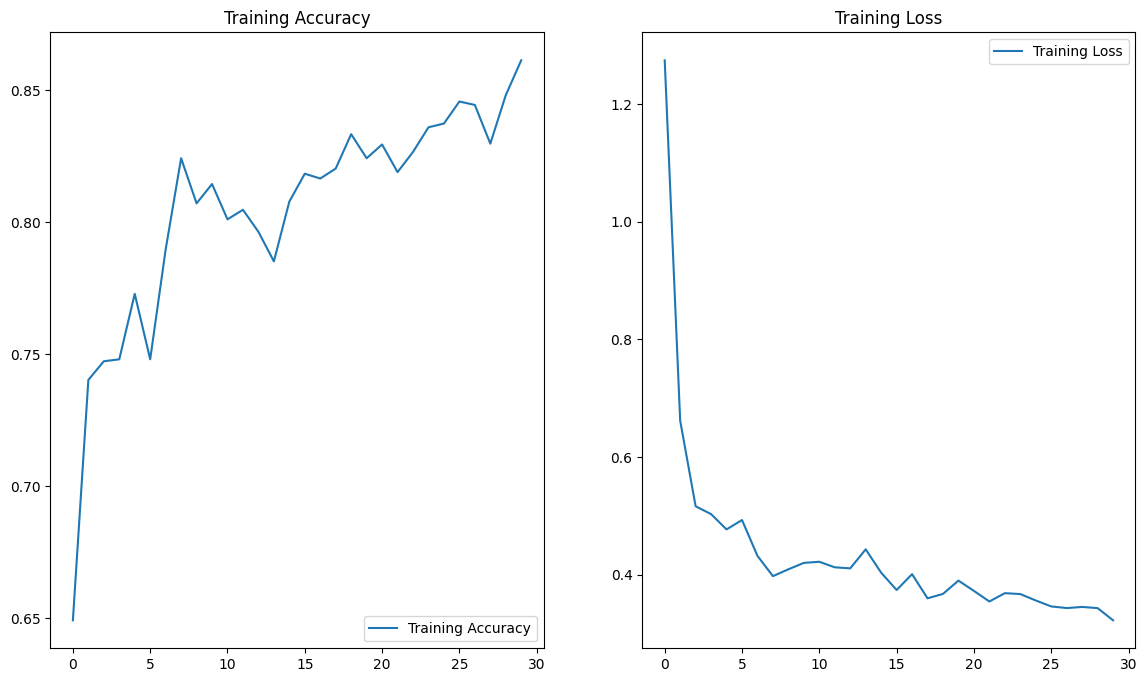

In [ ]:
plot_accuracy_loss(history, epochs)

In [24]:
model.save("ResNet_model.keras")
loaded_model = load_model("ResNet_model.keras")

### 6. Fine-tuning of the entire model

In [26]:
loaded_model.get_layer("resnet50v2").trainable = True
loaded_model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=1e-5),  # smaller LR for fine-tuning
    loss = tf.keras.losses.BinaryCrossentropy(), 
    metrics= metrics)

history = loaded_model.fit(
    full_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs
)
model.save("ResNet_finetuned_model.keras")

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 92s 6s/step - accuracy: 0.5971 - loss: 1.0851
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6771 - loss: 0.7415
Epoch 3/30


c:\Users\lotte\anaconda3\envs\aiproject\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


12/12 ━━━━━━━━━━━━━━━━━━━━ 74s 6s/step - accuracy: 0.7179 - loss: 0.6471
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.7814 - loss: 0.4879
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 71s 6s/step - accuracy: 0.7936 - loss: 0.4338
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8308 - loss: 0.3547
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 71s 6s/step - accuracy: 0.8604 - loss: 0.3391
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8544 - loss: 0.3379
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 72s 6s/step - accuracy: 0.8733 - loss: 0.3148
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8744 - loss: 0.2985
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 73s 6s/step - accuracy: 0.8858 - loss: 0.2708
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9112 - loss: 0.2466
Epoch 13/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 73s 6s/step - accuracy: 0.9073 - loss: 0.2519
Epoch 14/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9092 - loss: 0.221

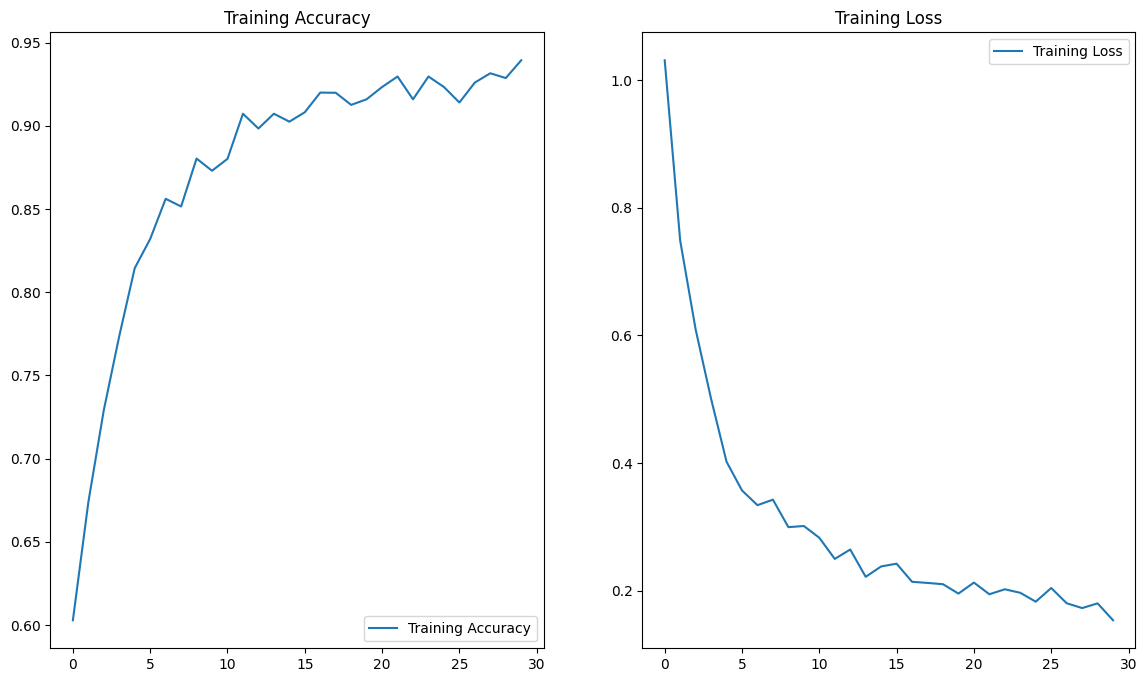

In [ ]:
plot_accuracy_loss(history, epochs)

In [30]:
final_model = load_model("ResNet_finetuned_model.keras")

In [31]:
test_data_gen = test_validation_data_Pipeline(batch_size, img_size, 'covid xray/train_val', test_dir)
loss, accuracy = final_model.evaluate(test_data_gen)

y_true = test_data_gen.classes
y_pred_probs = final_model.predict(test_data_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(classification_report(y_true, y_pred, target_names=test_data_gen.class_indices.keys()))

Found 2000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


c:\Users\lotte\anaconda3\envs\aiproject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7315 - loss: 0.5205
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Test Loss: 0.5213
Test Accuracy: 0.7300
              precision    recall  f1-score   support

       COVID       0.46      0.37      0.41       100
      NORMAL       0.47      0.57      0.52       100

    accuracy                           0.47       200
   macro avg       0.47      0.47      0.46       200
weighted avg       0.47      0.47      0.46       200



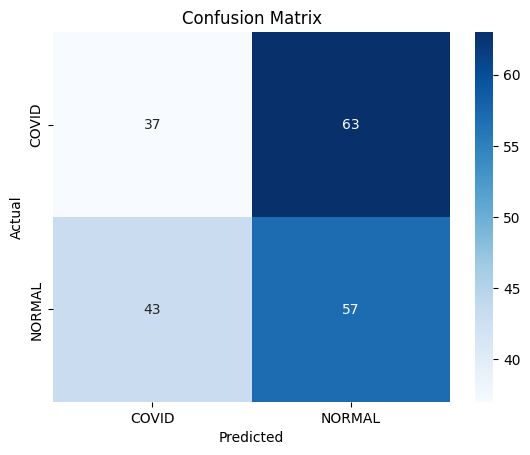

In [ ]:
plot_confusion_matrix(y_true, y_pred, test_data_gen)

In [ ]:
# Plot a few samples from the test dataset (without pre-processing) with their evaluations (after pre-processing).
